In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
import matplotlib.dates as mdates
import tensorflow as tf

from src.globals import processed_data_dir, saved_model_dir, vis_dir
from src.helpers import WindowGenerator, get_filenames_in_directory
from src.visualization import plot_metrics

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [4]:
# check GPU visibility
tf.config.get_visible_devices(
    device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
train_dir = processed_data_dir / 'train'
val_dir = processed_data_dir / 'val'
test_dir = processed_data_dir / 'test'

In [6]:
train_files = get_filenames_in_directory(train_dir)

In [7]:
# number of features
# 11
cols = pd.read_csv(train_dir/train_files[0]).columns
n_features = len(cols) -1  # number of columns without embedding column
n_features

11

In [8]:
# number of locations for embedding inputs
# 4
train_files = get_filenames_in_directory(train_dir)
n_locations = len(train_files)
n_locations

6

In [9]:
# Model configs
INPUT_WIDTH = 24  * 3
LABEL_WIDTH = 6
BATCH_SIZE = 32
N_FEATURES = n_features
N_OUTPUTS = 1
N_EMBEDDING_DIMS = n_locations

In [10]:
w1 = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, batch_size=BATCH_SIZE,
                     train_dir=train_dir, val_dir=val_dir, test_dir=test_dir,
                     label_columns=['Lufttemperatur [GradC]'],
                     embedding_column='Location')

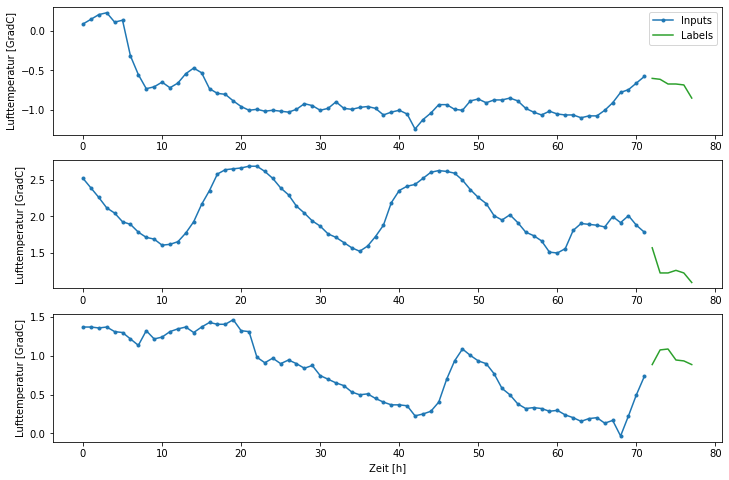

In [11]:
w1.plot()

# Define model & metrics

In [12]:
tf.keras.backend.clear_session()

# Input for embeddings
embedding_inputs = tf.keras.Input(shape =(INPUT_WIDTH,))
embedding_layer = tf.keras.layers.Embedding(input_dim=N_EMBEDDING_DIMS + 1, 
                                            output_dim=2, input_length=INPUT_WIDTH)(embedding_inputs)

# Input for features
feature_inputs = tf.keras.layers.Input(shape=(INPUT_WIDTH, n_features))

# Concat embeddings &  features
concat_layer = tf.keras.layers.Concatenate()([ embedding_layer, feature_inputs])

lstm_layer = tf.keras.layers.LSTM(30, return_sequences=True)(concat_layer)
lstm_layer = tf.keras.layers.LSTM(30, return_sequences=True)(lstm_layer)[:,-LABEL_WIDTH:,:]

# Apply a dense output layer on every timestep of the LSTM
output = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(units=1, activation='linear')
)

# Slice out only the necessary number of timesteps
output = output(lstm_layer)#[:,-LABEL_WIDTH:,:]

# Build the model
#model = tf.keras.Model(inputs=[feature_inputs, embedding_inputs], outputs=output)
model = tf.keras.Model(inputs=[feature_inputs, embedding_inputs], outputs=output)

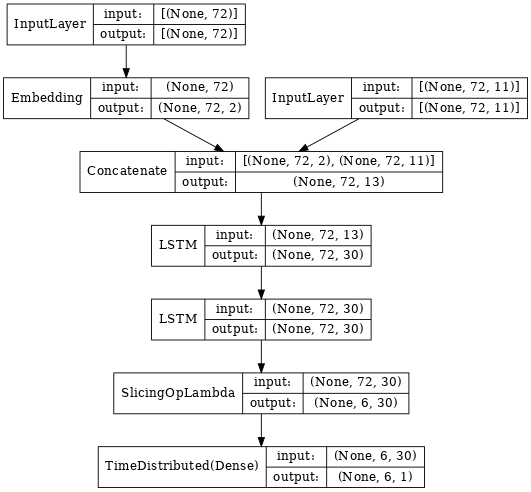

In [13]:
tf.keras.utils.plot_model(
    model, to_file=vis_dir/'lstm.png', show_shapes=True, 
    show_layer_names=False, rankdir='TB', expand_nested=False, dpi=64
)

# Train model

In [14]:
# Train configs
MAX_EPOCHS = 30

In [15]:
METRICS = [
      tf.keras.metrics.MeanAbsoluteError(name='MAE')
]

In [16]:
def compile_and_fit(model,
                    train_dataset,
                    validation_dataset,
                    save_to=None, 
                    patience=3, 
                    lr=1e-4, 
                    max_epochs=MAX_EPOCHS,
                    metrics=METRICS,
                    batch_size=BATCH_SIZE,
                    verbose=True):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)
    
    save_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_to,
                                                         save_weights_only=False,
                                                         monitor='val_loss',
                                                         mode='min',
                                                         save_best_only=True,
                                                         save_freq='epoch')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(lr=lr),
                metrics=metrics)

    history = model.fit(train_dataset, epochs=max_epochs,
                      validation_data=validation_dataset,
                      callbacks=[early_stopping],
                      batch_size=batch_size,
                      verbose=verbose)
                      
    return history

In [17]:
model_name = 'lstm_basic_' + \
        datetime.datetime.today().strftime('%y%m%d')

history = compile_and_fit(model, w1.train, w1.val, save_to=str(saved_model_dir/model_name))

Epoch 1/30
258/258 [==============================] - 45s 155ms/step - loss: 0.7677 - MAE: 0.6982 - val_loss: 0.3901 - val_MAE: 0.4730
Epoch 2/30
258/258 [==============================] - 53s 200ms/step - loss: 0.1961 - MAE: 0.3444 - val_loss: 0.3275 - val_MAE: 0.4315
Epoch 3/30
258/258 [==============================] - 55s 206ms/step - loss: 0.1427 - MAE: 0.2922 - val_loss: 0.2963 - val_MAE: 0.4103
Epoch 4/30
258/258 [==============================] - 55s 207ms/step - loss: 0.1273 - MAE: 0.2751 - val_loss: 0.2796 - val_MAE: 0.3983
Epoch 5/30
258/258 [==============================] - 55s 206ms/step - loss: 0.1198 - MAE: 0.2663 - val_loss: 0.2668 - val_MAE: 0.3885
Epoch 6/30
258/258 [==============================] - 55s 209ms/step - loss: 0.1130 - MAE: 0.2581 - val_loss: 0.2553 - val_MAE: 0.3786
Epoch 7/30
258/258 [==============================] - 56s 212ms/step - loss: 0.1072 - MAE: 0.2509 - val_loss: 0.2506 - val_MAE: 0.3744
Epoch 8/30
258/258 [==============================] - 5

In [18]:
model.save(str(saved_model_dir/model_name))

[2021-08-28 20:24:52 | save] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.
[2021-08-28 20:24:52 | save] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_basic_210828/assets


[2021-08-28 20:24:53 | builder_impl] Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_basic_210828/assets


Text(0, 0.5, 'val_loss')

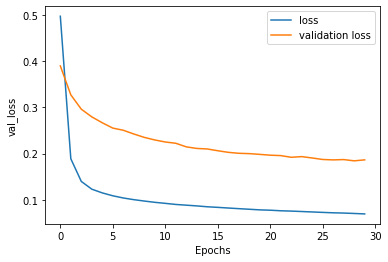

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(labels = ["loss", "validation loss"])
plt.xlabel("Epochs")
plt.ylabel("val_loss")

In [20]:
model.evaluate(w1.test)

42/42 [==============================] - 4s 52ms/step - loss: 0.1795 - MAE: 0.3116


[0.17951487004756927, 0.31160280108451843]

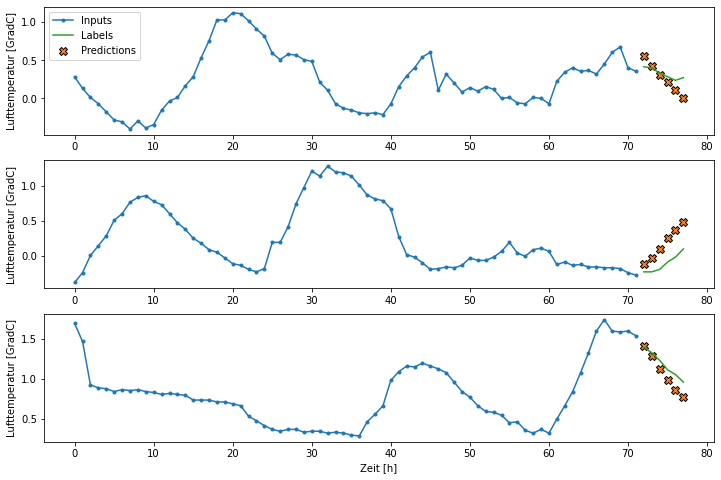

In [37]:
w1.plot(model=model)